In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch

/home/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_pkl_data(fname):
    with open(fname, 'rb') as f:
        data_dict = pickle.load(f)
    loss_info = np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])
    return loss_info

In [10]:
noise_level = 5.0
pw = 0.1

fname_lst = [
    f'data/benchmark/RUN_1/bayesian_baseline_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_2/bayesian_baseline_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_3/bayesian_baseline_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_4/bayesian_baseline_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_5/bayesian_baseline_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_1/bayesian_random_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_2/bayesian_random_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_3/bayesian_random_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_4/bayesian_random_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_5/bayesian_random_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_1/bayesian_gradientdesc_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_2/bayesian_gradientdesc_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_3/bayesian_gradientdesc_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_4/bayesian_gradientdesc_pw-{pw}_nl-{noise_level}_Nb-200.pkl',
    f'data/benchmark/RUN_5/bayesian_gradientdesc_pw-{pw}_nl-{noise_level}_Nb-200.pkl'
]

loss_info_lst = [read_pkl_data(f) for f in fname_lst]

In [11]:
index = torch.arange(3).repeat_interleave(5)
print(index)

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])


In [12]:
import torch_scatter

loss = torch.tensor(np.asarray(loss_info_lst))
loss_exp_mean = torch_scatter.scatter_mean(loss, index, dim=0)
loss_mean = loss_exp_mean.mean(dim=1)
loss_std = 0.25 * torch_scatter.scatter_std(loss, index, dim=0).mean(dim=1)

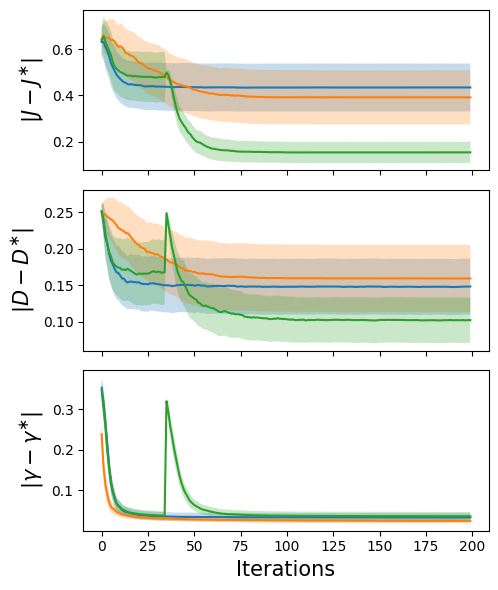

In [13]:
ylabels = ['J', 'D', '\gamma']

fig, ax = plt.subplots(3, 1, figsize=(5,6), sharex=True)
for i_ax in range(3):
    for i, (_mean, _std) in enumerate(zip(loss_mean, loss_std)):
        ax[i_ax].plot(np.arange(_mean.shape[0]), _mean[...,i_ax])
        ax[i_ax].fill_between(np.arange(_mean.shape[0]), _mean[...,i_ax]-_std[...,i_ax], _mean[...,i_ax]+_std[...,i_ax], alpha=0.25)
    ax[i_ax].set_ylabel(rf'$|{ylabels[i_ax]}-{ylabels[i_ax]}^{{\ast}}|$', fontsize=15)
ax[-1].set_xlabel('Iterations', fontsize=15)
fig.tight_layout()
fig.savefig(f"figs/paper/comparisons/pw-{pw}_nl-{noise_level}_Nb-200.pdf", bbox_inches='tight')

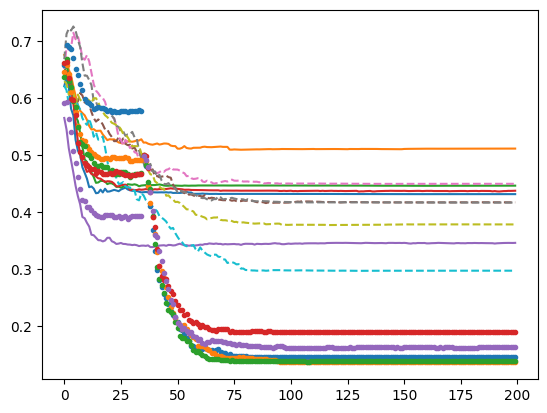

In [14]:
idx = 0
linestyles = ['-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '.', '.', '.', '.', '.']
# linestyles = ['-', '-', '--', '--', '.', '.']
fig, ax = plt.subplots(1, 1)
for i, _loss in enumerate(loss_info_lst):
    ax.plot(np.arange(_loss.shape[1]), _loss.mean(axis=0)[:,idx], linestyles[i])
    # ax.fill_between(np.arange(loss.shape[1]), 
    #     loss.mean(axis=0)[:,idx]-0.05*loss.std(axis=0)[:,idx],
    #     loss.mean(axis=0)[:,idx]+0.05*loss.std(axis=0)[:,idx], alpha=0.25)

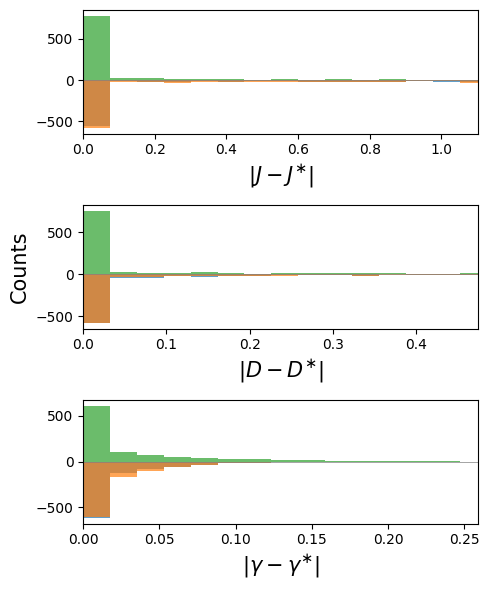

In [15]:
i_iter = -1

xlabels = ['J', 'D', '\gamma']

fig, ax = plt.subplots(3, 1, figsize=(5,6))
for i_ax in range(3):
    bins = np.linspace(0, loss[...,i_ax].max(), 50)
    for i_param in range(3):
        data = torch.cat(torch.unbind(loss[index==i_param], dim=0)).numpy()
        counts, bins = np.histogram(data[:,i_iter,i_ax], bins=bins)
        if i_param == 2:
            ax[i_ax].bar((bins[:-1]+bins[1:])/2, counts, width=bins[1]-bins[0], alpha=0.7)
        else:
            ax[i_ax].bar((bins[:-1]+bins[1:])/2, -counts, width=bins[1]-bins[0], alpha=0.7)
        # ax[i_ax].set_yscale('log')
    ax[i_ax].hlines(0, -10, 10, colors='gray', linestyles='-', linewidth=0.5)
    ax[i_ax].set_xlabel(rf'$|{xlabels[i_ax]}-{xlabels[i_ax]}^{{\ast}}|$', fontsize=15)
    ax[i_ax].set_xlim([0, 0.3 * loss[...,i_ax].max()])
    # ax[i_ax].set_yticks([-300,  0, 300])
    if i_ax == 1:
        ax[i_ax].set_ylabel('Counts', fontsize=15)
    # ax[i_ax].set_yticklabels(['-500', '0', '500'])
fig.tight_layout()
fig.savefig(f"figs/paper/comparisons/hist_pw-{pw}_nl-{noise_level}_Nb-200.pdf", bbox_inches='tight')

(-1.0, 3.0)

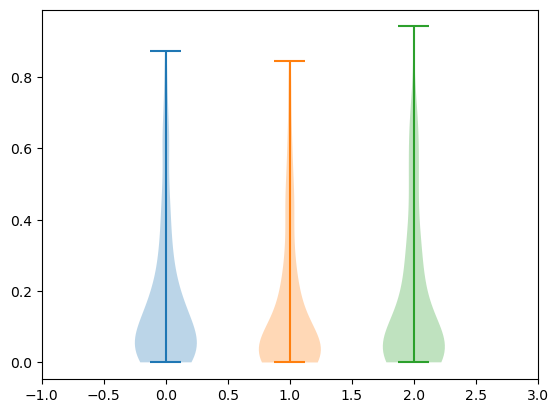

In [6]:
import seaborn as sns

idx = 1
iter_num = 10

fig = plt.figure()
ax = fig.add_subplot()
ax.violinplot(loss_info_lst[0][:,iter_num,idx], positions=[0])
ax.violinplot(loss_info_lst[4][:,iter_num,idx], positions=[1])
ax.violinplot(loss_info_lst[-1][:,iter_num,idx], positions=[2])
# sns.swarmplot(x=0*np.ones_like(loss_info_lst[0][:,iter_num,idx]), y=loss_info_lst[0][:,iter_num,idx], orient='v')
# sns.swarmplot(x=1*np.ones_like(loss_info_lst[4][:,iter_num,idx]), y=loss_info_lst[4][:,iter_num,idx], orient='v')
# sns.swarmplot(x=2*np.ones_like(loss_info_lst[-1][:,iter_num,idx]), y=loss_info_lst[-1][:,iter_num,idx], orient='v')
ax.set_xlim([-1, 3])
# ax.set_yscale('log')

In [7]:
with open('data/benchmark/bayesian_baseline_pw-0.1_nl-5.0_Nb-200.pkl', 'rb') as f:
    baseline_dict = pickle.load(f)
# with open('data/benchmark/bayesian_baseline_pw-0.1_nl-10.0_Nb-200.pkl', 'rb') as f:
#     baseline_dict_nl10 = pickle.load(f)
with open('data/benchmark/bayesian_random_pw-0.1_nl-5.0_Nb-200.pkl', 'rb') as f:
    random_dict = pickle.load(f)
with open('data/benchmark/bayesian_gradientdesc_pw-0.1_nl-5.0_Nb-200.pkl', 'rb') as f:
    gd_dict = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/benchmark/bayesian_baseline_pw-0.1_nl-5.0_Nb-200.pkl'

In [ ]:
l1_diff_baseline = np.abs(baseline_dict['param_mean'] - baseline_dict['param_true'][:,None,:])
# l1_diff_baseline_nl10 = np.abs(baseline_dict_nl10['param_mean'] - baseline_dict_nl10['param_true'][:,None,:])
l1_diff_random = np.abs(random_dict['param_mean'] - random_dict['param_true'][:,None,:])
l1_diff_gd = np.abs(gd_dict['param_mean'] - gd_dict['param_true'][:,None,:])

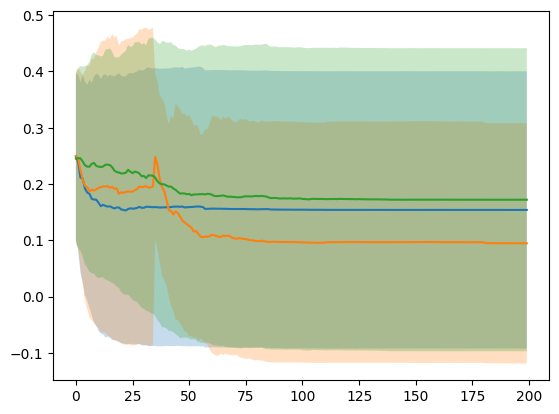

In [ ]:
idx = 1

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(l1_diff_baseline.shape[1]), l1_diff_baseline.mean(axis=0)[:,idx])
ax.fill_between(np.arange(l1_diff_baseline.shape[1]), 
    l1_diff_baseline.mean(axis=0)[:,idx]-l1_diff_baseline.std(axis=0)[:,idx],
    l1_diff_baseline.mean(axis=0)[:,idx]+l1_diff_baseline.std(axis=0)[:,idx], alpha=0.25)

# ax.plot(np.arange(l1_diff_baseline_nl10.shape[1]), l1_diff_baseline_nl10.mean(axis=0)[:,idx])
# ax.fill_between(np.arange(l1_diff_baseline_nl10.shape[1]), 
#     l1_diff_baseline_nl10.mean(axis=0)[:,idx]-l1_diff_baseline_nl10.std(axis=0)[:,idx],
#     l1_diff_baseline_nl10.mean(axis=0)[:,idx]+l1_diff_baseline_nl10.std(axis=0)[:,idx], alpha=0.25)

ax.plot(np.arange(l1_diff_gd.shape[1]), l1_diff_gd.mean(axis=0)[:,idx])
ax.fill_between(np.arange(l1_diff_gd.shape[1]), 
    l1_diff_gd.mean(axis=0)[:,idx]-l1_diff_gd.std(axis=0)[:,idx],
    l1_diff_gd.mean(axis=0)[:,idx]+l1_diff_gd.std(axis=0)[:,idx], alpha=0.25)

ax.plot(np.arange(l1_diff_random.shape[1]), l1_diff_random.mean(axis=0)[:,idx])
ax.fill_between(np.arange(l1_diff_random.shape[1]), 
    l1_diff_random.mean(axis=0)[:,idx]-l1_diff_random.std(axis=0)[:,idx],
    l1_diff_random.mean(axis=0)[:,idx]+l1_diff_random.std(axis=0)[:,idx], alpha=0.25)